# Critical Collapse Study

Below is code to help study the formation of black holes. The equations integrated are described in the work by Bloomfield et. al.

arXiv paper on : [1504.02071](https://arxiv.org/pdf/1504.02071.pdf) ([ar5iv](https://ar5iv.org/abs/1504.02071))

For collapse with an approximate QCD equation of state, a previous work is

arXiv: [1801.06138](https://arxiv.org/pdf/1801.06138.pdf) ([ar5iv](https://ar5iv.org/abs/1801.06138))

## Import Modules

In [1]:
import sys
from importlib import reload 
import scipy.interpolate as interp
import scipy.constants as const
from scipy import stats
import subprocess
import numpy as np
import scipy.optimize as opt

import ctypes
c_lib = ctypes.CDLL('cpp/ms.so')
c_real_t = ctypes.c_double
c_bool_t = ctypes.c_bool
c_real_ptr_t = ctypes.POINTER(c_real_t)

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rc('xtick', direction='in', top=True)
mpl.rc('ytick', direction='in', right=True)
mpl.rc('xtick.minor', visible=True)
mpl.rc('ytick.minor', visible=True)

## Equation of state information

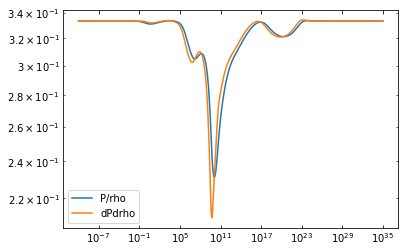

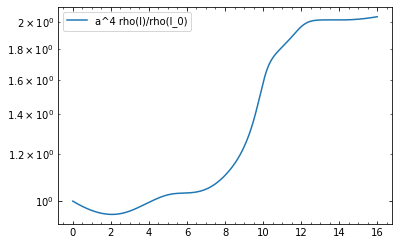

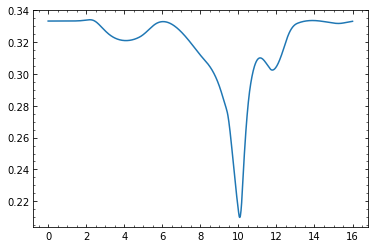

In [2]:
c_lib.P_of_rho.restype = c_real_t
c_lib.P_of_rho.argtypes = [c_real_t]
c_lib.dPdrho.restype = c_real_t
c_lib.dPdrho.argtypes = [c_real_t]

c_lib.rho_background.restype = c_real_t
c_lib.rho_background.argtypes = [c_real_t]
c_lib.P_background.restype = c_real_t
c_lib.P_background.argtypes = [c_real_t]

c_lib.G.restype = c_real_t
c_lib.G.argtypes = [c_real_t]

rhos = np.logspace(-10,35,500)

ps = np.array([c_lib.P_of_rho(rho)/rho for rho in rhos])
plt.loglog(rhos, ps, label="P/rho")
dps = np.array([c_lib.dPdrho(rho) for rho in rhos])
plt.loglog(rhos, dps, label="dPdrho")
plt.legend();

plt.figure(2)
ls = np.linspace(0.0, 16, 1000)
plt.semilogy(ls, [np.exp(2*l)/c_lib.G(l) for l in ls ], label="a^4 rho(l)/rho(l_0)");
plt.legend();

plt.figure(3)
plt.plot(ls, [c_lib.dPdrho(c_lib.rho_background(l)) for l in ls])

## Boilerplate for runs

In [3]:
c_lib.ics.argtypes = [ c_real_ptr_t, c_real_ptr_t, c_real_ptr_t,
    c_real_ptr_t, c_real_t, c_real_t, ctypes.c_int, c_real_t, c_bool_t ]
c_lib.ics.restype = None

c_lib.run_sim.argtypes = [ c_real_ptr_t, c_real_ptr_t, c_real_ptr_t, c_real_ptr_t,
                          ctypes.c_int, ctypes.c_int,
                          c_bool_t, c_real_t, c_bool_t, c_bool_t,
                          ctypes.c_int, c_real_t, c_real_t, c_real_t]
c_lib.run_sim.restype = ctypes.c_int

c_lib.regrid.argtypes = [ c_real_ptr_t, c_real_t, c_real_t ]
c_lib.regrid.restype = None
c_lib.agg_pop.argtypes = [ c_real_ptr_t, c_real_t ]
c_lib.agg_pop.restype = None

In [4]:
def comboplot(agg) :
    Ab = agg[0]
    plt.rcParams["figure.figsize"] = (20,6)
    
    def myplot(f, c) :
        plt.loglog(Ab, f, ls='-', color=c)
        plt.loglog(Ab, -f, ls=':', color=c)

    Rt = agg[1]; myplot(Rt, "limegreen")
    mt = agg[2]; myplot(mt, "green")
    Ut = agg[3]; myplot(Ut, "lawngreen")
    dRtdAb = agg[4]; myplot(dRtdAb, "pink")
    dmtdAb = agg[5];
    gammab2 = agg[6]; myplot(gammab2, "navy")
    rhot = agg[7]; myplot(rhot, "blue")
    Pt = agg[8]; myplot(Pt, "deepskyblue")
    dPtdAb = agg[9]; myplot(dPtdAb, "tomato")
    phi = agg[10]; myplot(np.exp(phi), "firebrick")
    m2oR = agg[11]; myplot(m2oR, "yellow")
    Qt = agg[12]; myplot(Qt, "skyblue")
    
    plt.hlines(1.0, Ab[0], Ab[-1], colors='k')
    plt.ylim(1.0e-5, 1.0e7);

In [39]:
def min_gammab2(amp, l_simstart, l_simeq, USE_FIXW=False, Ld=30, N=3200) :
    max_rho0 = c_real_t(0)
    deltaH = c_real_t(-2)
    agg = (c_real_t*(N*13))()
    l = c_real_t(l_simstart)
    c_lib.ics(agg, ctypes.byref(l), ctypes.byref(deltaH), ctypes.byref(max_rho0),
              amp*c_lib.G(l_simstart)/c_lib.G(l_simeq), # Amplitude scaled down by the relative growth factor
              np.exp(l_simeq), # Abar scale set by the equality factor
              N, Ld, USE_FIXW)
    agg = np.reshape(np.copy(agg), (13, N))
    gammab2 = agg[6];
    return np.min(gammab2)

def max_phys_amp(l_simstart, l_simeq, USE_FIXW=False, Ld=30, N=3200) :
    return opt.root( min_gammab2, 0.5, (l_simstart, l_simeq, USE_FIXW, Ld, N) ).x[0]

### Testing

In [72]:
steps=10000
N=800
Ld=32.0
USE_FIXW=False
regrid_lam=0.001
regrid_nu=1.0
regrid_int=-400
horizon_stop=True
q_mult=0.25
TOL=1.0e-7

max_rho0 = c_real_t(0)
deltaH = c_real_t(-2)
agg = (c_real_t*(N*13))()

aggs = []

for i in np.linspace(0,0,1) :
    l_simstart = 0
    l_simeq = i
    amp = 0.9*max_phys_amp(l_simstart, l_simeq, USE_FIXW, Ld, N)
    
    l = c_real_t(l_simstart)
    c_lib.ics(agg, ctypes.byref(l), ctypes.byref(deltaH), ctypes.byref(max_rho0),
              amp*c_lib.G(l_simstart)/c_lib.G(l_simeq), # Amplitude scaled down by the relative growth factor
              np.exp(l_simeq), # Abar scale set by the equality factor
              N, Ld, USE_FIXW)
    res = c_lib.run_sim(agg, ctypes.byref(l), ctypes.byref(deltaH), ctypes.byref(max_rho0),
                        steps, -1, horizon_stop, q_mult, True, True,
                        regrid_int, regrid_lam, regrid_nu, TOL)
    aggs.append(np.reshape(np.copy(agg), (13, N)))
    print(res, l, amp, c_lib.G(l_simstart)/c_lib.G(l_simeq), deltaH, max_rho0)

3 c_double(1.2013095384709358) 0.9273598013335856 1.0 c_double(0.5637157176643848) c_double(243.4093522633602)


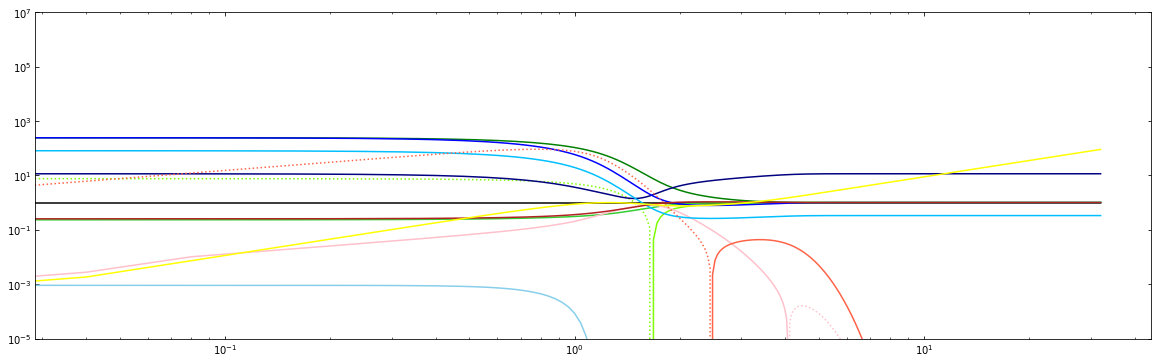

In [73]:
[ comboplot(agg) for agg in aggs ];

In [62]:
steps=10000
N = 800
Ld=32.0
USE_FIXW=False
regrid_lam=0.001
regrid_nu=1.0
regrid_int=-400
horizon_stop=True
q_mult=0.25
TOL=1.0e-7

max_rho0 = c_real_t(0)
deltaH = c_real_t(-2)
agg = (c_real_t*(N*13))()

aggs = []

for i in np.linspace(0,0,1) :
    l_simstart = i
    l_simeq = i
#     amp = 0.9*max_phys_amp(l_simstart, l_simeq, USE_FIXW, Ld, N)
    amp = 0.5667
    
    l = c_real_t(l_simstart)
    c_lib.ics(agg, ctypes.byref(l), ctypes.byref(deltaH), ctypes.byref(max_rho0),
              amp*c_lib.G(l_simstart)/c_lib.G(l_simeq), # Amplitude scaled down by the relative growth factor
              np.exp(l_simeq), # Abar scale set by the equality factor
              N, Ld, USE_FIXW)
    res = c_lib.run_sim(agg, ctypes.byref(l), ctypes.byref(deltaH), ctypes.byref(max_rho0),
                        steps, -1, horizon_stop, q_mult, True, True,
                        regrid_int, regrid_lam, regrid_nu, TOL)
    aggs.append(np.reshape(np.copy(agg), (13, N)))
    print(res, l, c_lib.G(l_simstart)/c_lib.G(l_simeq),  deltaH, max_rho0)

2 c_double(1.77084025835609) 1.0 c_double(0.33754997799738223) c_double(13.30886295548608)


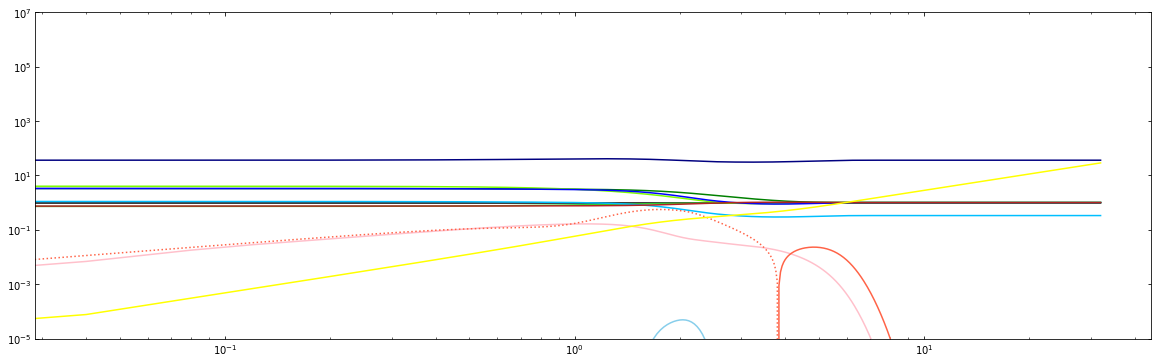

In [63]:
[ comboplot(agg) for agg in aggs ];

In [126]:
raise "STOP"

TypeError: exceptions must derive from BaseException

## Binary search for critical point

In [82]:
def find_crit(iters=12,
    l_simstart=0,
    l_simeq=0,
    lower_amp=-1,
    upper_amp=-1,
    steps=100000,
    N=800,
    Ld=32.0,
    USE_FIXW=False,
    q_mult=0.25,
    TOL=1.0e-7
):
    """
    Binary search between lower and upper to find a critical amplitude
    (Note that this is NOT the critical density)
    return (critical, upper value)
    """
    if lower_amp < 0 :
        lower_amp = 0.2*max_phys_amp(l_simstart, l_simeq, USE_FIXW, Ld, N)
    if upper_amp < 0 :
        upper_amp = 0.9*max_phys_amp(l_simstart, l_simeq, USE_FIXW, Ld, N)
    upper_fields = -1
    lower_fields = -1
    bisection_factor = 1/2
    for i in range(iters):
        try :
            amp_diff = upper_amp - lower_amp
            middle_amp = upper_amp - amp_diff*bisection_factor
            print('Iteration No', str(i), '-- Checking to see if a BH forms at amplitude', str(middle_amp),
                ' ( bracket is ', lower_amp, '/', upper_amp, ')')

            deltaH = c_real_t(-2)
            max_rho0 = c_real_t(0)
            agg = (c_real_t*(N*13))()
            l = c_real_t(l_simstart)
           
            c_lib.ics(agg, ctypes.byref(l), ctypes.byref(deltaH), ctypes.byref(max_rho0),
                      middle_amp*c_lib.G(l_simstart)/c_lib.G(l_simeq), np.exp(l_simeq), N, Ld, USE_FIXW)

            result = c_lib.run_sim(agg, ctypes.byref(l), ctypes.byref(deltaH), ctypes.byref(max_rho0),
                                steps, -1, True, q_mult, True, True, -400, 1.0, 0.001, TOL)
            print(result, l, c_lib.G(l_simstart)/c_lib.G(l_simeq), deltaH, max_rho0)
            
            fields = np.reshape(np.copy(agg), (13, N))

            if result == 0 : # Ran out of steps
                print("Ran out of steps. Breaking.")
                break
            elif result <= 1 : # Some sort of error during run
                print("Encountered error during run. Trying again with a different amplitude.")
                # change bisection factor (don't divide just in half; walk in by 1/4, 1/8, ... from the ends.)
                if bisection_factor >= 1/2 :
                    bisection_factor = (1-bisection_factor)/2
                else :
                    bisection_factor = 1-bisection_factor
            else :
                bisection_factor = 1/2
                if(result == 3):
                    upper_amp = middle_amp
                    upper_fields = fields
                elif(result == 2):
                    lower_amp = middle_amp
                    lower_fields = fields

        except Exception as e :
            print("Run failed! Stopping search. Reason below.")
            print(e)
            break
    
    print("Critical amplitude appears to be between", lower_amp, "and", upper_amp)
    try :
        comboplot(upper_fields)
        plt.figure(2)
        comboplot(lower_fields)
    except :
        pass

    return (lower_amp, upper_amp)

Iteration No 0 -- Checking to see if a BH forms at amplitude 0.71  ( bracket is  0.7 / 0.72 )
2 c_double(2.078750344653821) 1.0 c_double(0.42752140509437675) c_double(758.9452976349426)
Iteration No 1 -- Checking to see if a BH forms at amplitude 0.715  ( bracket is  0.71 / 0.72 )
2 c_double(2.1895180036777653) 1.0 c_double(0.43065722847332033) c_double(4256.9444216738575)
Iteration No 2 -- Checking to see if a BH forms at amplitude 0.7175  ( bracket is  0.715 / 0.72 )
3 c_double(2.085624243000872) 1.0 c_double(0.43222584587135887) c_double(134576.10910827437)
Iteration No 3 -- Checking to see if a BH forms at amplitude 0.71625  ( bracket is  0.715 / 0.7175 )
3 c_double(2.2265528321823242) 1.0 c_double(0.43144128445682556) c_double(918539.1835274876)
Iteration No 4 -- Checking to see if a BH forms at amplitude 0.715625  ( bracket is  0.715 / 0.71625 )
2 c_double(2.231681202252583) 1.0 c_double(0.4310492667201222) c_double(9366.803640967155)
Iteration No 5 -- Checking to see if a BH for

(0.7159960937500001, 0.716171875)

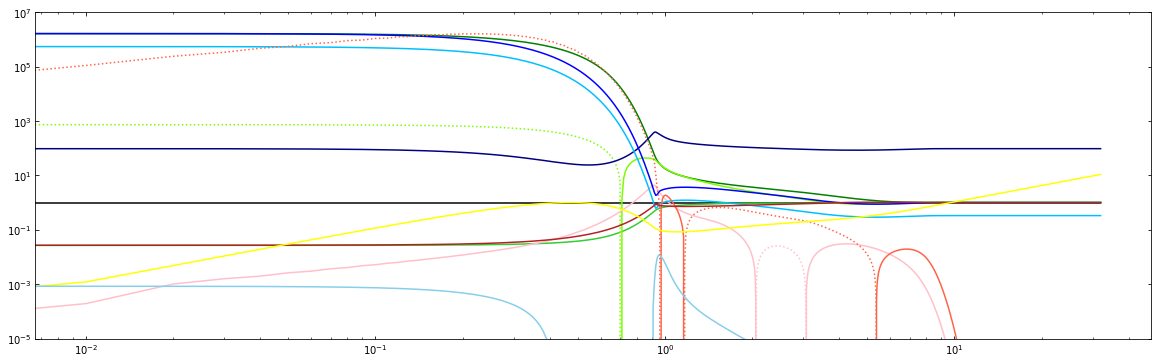

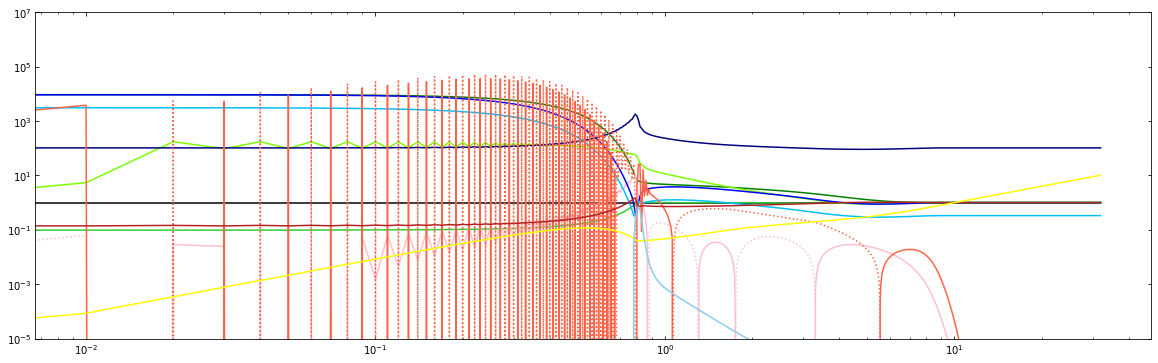

In [83]:
find_crit(iters=12, l_simstart=0, l_simeq=0,
          lower_amp=0.70, upper_amp=0.72,
          N=3200, USE_FIXW=False, q_mult=0.2, TOL=1e-8)

## Mass finding

In [ ]:
def find_mass(Abar, rho0, amp, mOverR_thresh=0.98,
        is_searching_for_crit=False, ms_steps=1500000,
        MS_sm_sigma=0.0,
        hm_steps=1500000, HM_sm_sigma=15.0,
        HM_Abar=None, # can specify a different Abar for HM run
        HM_cflfac=0.1
    ):
    """
    Find mass of BHs for certain amplitude
    set is_searching_for_crit=True when searching for the critical point
    """
    print('Finding mass with amp ' + str(amp))
            
    # Perform an MS run without raytracing to get the overdensity delta
    ms = MS(Abar, rho0, amp, trace_ray=False, BH_threshold=-1e1, sm_sigma=MS_sm_sigma)
    ms.adap_run_steps(ms_steps)
    delta = ms.delta
    
    # Perform an MS run with raytracing to get ICs for an HM run
    ms = MS(Abar, rho0, amp, trace_ray=True, BH_threshold=-1e1, sm_sigma=MS_sm_sigma)
    flag = ms.adap_run_steps(ms_steps)
    if(flag != 0):
        raise ValueError('Not finishing ray-tracing with the amplitude ' + str(amp))
        
    # Perform an HM run
    hm = HM(ms, mOverR=mOverR_thresh, sm_sigma=HM_sm_sigma, Abar=HM_Abar, cflfac=HM_cflfac)
    bh_formed = hm.run_steps(hm_steps) == 1
    if(not bh_formed and is_searching_for_crit==False):
        print('Unable to reach the target 2m/R with the amplitude ' + str(amp))
    
    return (delta, hm.BH_mass2(), ms, hm)

In [ ]:
# Generate critical scaling data 
def critical_scaling_data(Abar, rho0, crit_amp, lower_amp, upper_amp, n=10, mOverR_thresh=0.98,
    MS_sm_sigma=0.0, HM_sm_sigma=15.0, HM_Abar=None, HM_cflfac=0.1):
    
    amps = 10**np.linspace(np.log10(lower_amp - crit_amp), np.log10(upper_amp - crit_amp), n) + crit_amp
    print("Attempting to find masses for runs with amplitudes:\n", amps)
    
    masses = [find_mass(Abar, rho0, amp, mOverR_thresh=mOverR_thresh, is_searching_for_crit=True,
        MS_sm_sigma=MS_sm_sigma, HM_sm_sigma=HM_sm_sigma, HM_Abar=HM_Abar, HM_cflfac=HM_cflfac) for amp in amps]
    return masses

## Simulation setup

Code below will set up grids (arrays) for running the simulations.

In [ ]:
# simulation resolution parameter
# (Not exactly the number of gridpoints for a mixed grid)
n_mix = 400
n_uni = 400

# Generate an array of coordinate positions for the simulation to run at
lower = np.log(5.65) # The coordinates will be linearly spaced from 0 to e^lower
upper = np.log(21.0) # The coordinates will be log spaced from e^lower to e^upper
Abar_mix = mix_grid(lower, upper, n_mix)
Abar_uni = uni_grid(upper, n_uni)
Abar_mix2 = mix_grid(lower, upper, n_mix//2)
Abar_uni2 = uni_grid(upper, n_uni//2)

plt.plot(Abar_mix, 'k.')
plt.plot(Abar_uni, 'b.')
print("The grid of Abar values is linearly spaced from Abar = 0 to", np.exp(lower),
      "then log spaced until Abar =", np.exp(upper))

## Critical scaling parameters

In [ ]:
# Find bounds on a critical point

# lower_amp, upper_amp = find_crit(Abar_mix, # Coordinate grid
#                                  1.0e0, # initial density 
#                                  0.15, # Amplitude a BH does *not* form
#                                  0.3, # amplitude a BH *does* form
#                                  steps=25000,
#                                  sm_sigma=0.5, # Hopefully no smoothing is needed here
#                                  fixw=False # Fixed equation of state or not?
#                                 )

In [ ]:
reload(ms_hm.MS)
from ms_hm.MS import *

ms = MS(Abar_uni, 1.0e0, 0.27, trace_ray=False, fixw=True)
ms.adap_run_steps(0)
print(ms.xi)

In [ ]:
def loadData(N) :
    data = np.fromfile("cpp/output.dat", dtype=np.float64)
    data = np.reshape(arr, (len(data)//N,N))
    print(arr.shape)

    R = data[0::13, :]
    m = data[1::13, :]
    U = data[2::13, :]
    Abar = data[3, :]
    m2oR = data[11::13, :]
    phi = data[10::13, :]
    P = data[8::13, :]
    Q = data[12::13, :]
    Pprime = data[9::13, :]

    n = -1
    plt.loglog(Abar, phi[n], "c-", label="phi");
    plt.loglog(Abar, -phi[n], "c:", label=None);
    plt.loglog(Abar, R[n], label="R");
    plt.loglog(Abar, m[n], label="m");
    plt.loglog(Abar, U[n], "g-", label="U");
    plt.loglog(Abar, -U[n], "g:");
    plt.loglog(Abar, m2oR[n], "k", label="2m/R");
    plt.loglog(Abar, P[n], "r", label="P");
    plt.loglog(Abar, Q[n], "m:", label="Q");
    plt.hlines(1,0,Abar[-1],"k")

    plt.legend()
    plt.ylim(1.0e-3, 1.0e4);

In [ ]:
N = 800;
call = subprocess.run("cd cpp; make clean && make fast=1 && ./ms -N "+str(N)+" -s 20000 -o 0 -a 0.272", 
            stdout=subprocess.PIPE, shell=True)
print(call.stdout.decode())
loadData(N)

In [ ]:
msPp = ms.Pprime(ms.R, ms.m, ms.U)
msrho = ms.rho(ms.R, ms.m)
msP = ms.P(msrho, ms.R, ms.U)
msPp2 = dfdA(msP, ms.Abar)
mspsi = ms.psi(msrho, msP, msPp)
mspsi2 = ms.psi(msrho, msP, msPp2)

plt.plot(ms.Abar, msPp)
plt.plot(ms.Abar, msPp2)
plt.plot(Abar, Pprime[0])

# plt.plot( mspsi)
# plt.plot( mspsi2)
# plt.plot(phi[0])

## Hernandez-Misner runs

In [ ]:
delta, mass, ms, hm = find_mass(Abar_mix, 1.0e0, 0.2727, mOverR_thresh=0.994,
          MS_sm_sigma=0.0, hm_steps=10, HM_sm_sigma=30.0, HM_Abar=Abar_mix, HM_cflfac=0.1)

In [ ]:
import copy 
reload(ms_hm.HM)
from ms_hm.HM import *

steps = 3000

hm = HM(ms, mOverR=0.95, sm_sigma=0.2, Abar=Abar_uni, cflfac=0.1)
Us, Ms, Rs, xis, rhops = [], [], [], [], []
try :
    for n in range(steps):
        hm.run_steps(hm.step+1)
        Us.append(copy.deepcopy(hm.U))
        Ms.append(copy.deepcopy(hm.m))
        Rs.append(copy.deepcopy(hm.R))
        xis.append(copy.deepcopy(hm.xi))
        rhops.append(copy.deepcopy(hm.rho_p))
except :
    pass

hm2 = HM(ms, mOverR=0.95, sm_sigma=0.1, Abar=Abar_uni2, cflfac=0.1)
Us2, Ms2, Rs2, xis2, rhops2 = [], [], [], [], []

try :
    for n in range(steps//2):
        hm2.run_steps(hm2.step+1)
        Us2.append(copy.deepcopy(hm2.U))
        Ms2.append(copy.deepcopy(hm2.m))
        Rs2.append(copy.deepcopy(hm2.R))
        xis2.append(copy.deepcopy(hm2.xi))
        rhops2.append(copy.deepcopy(hm2.rho_p))
except :
    pass


In [ ]:
for n in range(0,len(Us),100) :
    
    plt.loglog(hm.Abar+hm.Abar[1], Us[n], color='b')
    plt.loglog(hm2.Abar+hm.Abar[1], Us2[n//2], color='r')
    
    plt.loglog(hm.Abar+hm.Abar[1], rhops[n], color='y')
    plt.loglog(hm2.Abar+hm.Abar[1], rhops2[n//2], color='g')


In [ ]:
import matplotlib.animation
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams["animation.html"] = "jshtml"
plt.rcParams['figure.dpi'] = 150
plt.ioff()
fig, ax = plt.subplots()

nn = len(Us)
frames = 100
ii = nn//frames

def animate(j):
    i = ii*j-ii+1
    R, m, U, xi = Rs[i], Ms[i], Us[i], xis[i]
    
    g = hm.gamma(R, m, U, xi)
    xiprime = WENO_dfdA(xi, hm.Abar, 1e100)
    Rprime = WENO_dfdA(R, hm.Abar, 1e100)
    mprime = WENO_dfdA(m, hm.Abar, 1e100)
    Uprime = WENO_dfdA(U, hm.Abar, 1e100)

    r = hm.rho(R, m, U, xi, g, xiprime, Rprime, mprime)
    p = hm.P(r)

    plt.cla()
#     plt.semilogy(p[:50])
#     plt.semilogy(r[:50])
    plt.plot((p/r)[:50])
#     plt.plot(U[:50])


matplotlib.animation.FuncAnimation(fig, animate, frames=frames)


In [ ]:
# Get data to generate critical scaling exponent
crit_amp = (lower_amp+upper_amp)/2 # best guess for critical amplitude
data_lower_amp = upper_amp # look for critical data at/above the upper bound for the critical point
data_upper_amp = 1.05*upper_amp # Look for critical data at up to 5% larger amplitudes

scaling_data = critical_scaling_data(Abar_mix,
                      1.0e0, # Same density as above
                      crit_amp,
                      data_lower_amp,
                      data_upper_amp,
                      n=10, # Try to get masses at 10 points
                      mOverR_thresh=0.97,
                      MS_sm_sigma=0.0, HM_sm_sigma=15.0, HM_Abar=None, HM_cflfac=0.1)

In [ ]:
# importing MS and HM modules. Reload modules if needed
try :
    reload(ms_hm.QCD_EOS)
    reload(ms_hm.MS)
    reload(ms_hm.HM)
except :
    print("Did not reload modules, they may not have been imported yet.")

import ms_hm
from ms_hm.QCD_EOS import *
from ms_hm.MS import *
from ms_hm.HM import *

hm = HM(ms, mOverR=0.99, sm_sigma=14)
hm.run_steps(100)



## Critical data fit

Below is an example of all the code needed to find the critical scaling threshhold and exponent.

In [ ]:
# Find the critical point. It will be bounded between crit and lower.
(crit, lower) = find_crit()
# Find the mass of BHs at various amplitudes between lower_amp and lower_amp plus a bit.
res = critical_scaling(crit, lower_amp, lower_amp + 1e-2, 20)

In [ ]:
(a, b ) = np.polyfit(np.log10(res2[0][:,0] - res2[1])[:], np.log10(res2[0][:,1])[:], deg=1)
plt.scatter(np.log10(res2[0][:,0] - res2[1])[:], np.log10(res2[0][:,1])[:])
plt.plot(np.arange(-3.1,-1.6,0.01), a * np.arange(-3.1,-1.6,0.01) + b)

In [ ]:
np.polyfit(np.log10(res[0][:,0] - 0.4265539636281781)[:], np.log10(res[0][:,1])[:], deg=1)